In [1]:
import os
import urllib
import pandas
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML
datadir = '/home/idies/workspace/Temporary/raddick/cra_scratch/'
inflationdir = '/home/idies/workspace/Storage/raddick/Baltimore/inflation/'
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
figdir = thisdir+'figures/'

print('ok')

ok


In [ ]:
#s = time.time()
#tracts_df = pandas.read_csv(datadir+'tracts_processed.csv', low_memory=False, index_col='rownumber')
#e = time.time()
#print('Read {0:,.0f} rows in {1:,.0f} minutes {2:,.0f} seconds!'.format(
#    len(tracts_df), 
#    np.floor((e-s) / 60), 
#    (e-s) % 60
#))
##print('removing tracts with no loans received...')
##tracts_df = tracts_df[tracts_df['loan_indicator'] == 'Y']
#print('getting only St. Louis City tracts...')
#stl_tracts_df = tracts_df[
#    (tracts_df['state'] == 29)
#    & (tracts_df['county'] == 510)
#]
#print('backing up...')
#stl_tracts_df_bk = stl_tracts_df
#print('ok')

In [ ]:
#s = time.time()
#loans_df = pandas.read_csv(datadir+'loans_processed.csv', low_memory=False, index_col='rownumber')
#e = time.time()
#print('Read {0:,.0f} rows in {1:,.0f} minutes {2:,.0f} seconds!'.format(
#    len(loans_df), 
#    np.floor((e-s) / 60), 
#    (e-s) % 60
#))
#print('getting only St. Louis City tracts...')
#stl_loans_df = loans_df[
#    (loans_df['state'] == 29)
#    & (loans_df['county'] == 510)
#]
#print('backing up...')
#stl_loans_df_bk = stl_loans_df
#print('ok')

In [ ]:
#print('reading aggregate data...')
#stl_agg_df = pandas.read_csv('datasets/stl/stl_loans_by_census_tract_2010_2017.csv')
#print('backing up...')
#stl_agg_df_bk = stl_agg_df
#print('ok')

In [ ]:
#os.chdir('/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/')
#stl_tracts_df.to_csv(thisdir+'datasets/stl/stl_tracts.csv')
#stl_loans_df.to_csv(thisdir+'datasets/stl/stl_loans.csv')
#print('done!')

In [2]:
stl_tracts_df = pandas.read_csv('datasets/stl/stl_tracts.csv', encoding='utf-8', low_memory=False, index_col='rownumber')
stl_loans_df = pandas.read_csv('datasets/stl/stl_loans.csv', encoding='utf-8', low_memory=False, index_col='rownumber')

print('Loaded St. Louis data!')
print('backing up...')
stl_tracts_df_bk = stl_tracts_df
stl_loans_df_bk = stl_loans_df

print('ok')


Loaded St. Louis data!
backing up...
ok


In [5]:
print('getting from backup...')
stl_loans_df = stl_loans_df_bk
stl_tracts_df = stl_tracts_df_bk

print('calculating total number and amount of loans...')
stl_loans_df = stl_loans_df.assign(nLoans = stl_loans_df['nLoans1'] 
                                                         + stl_loans_df['nLoans100k'] 
                                                         + stl_loans_df['nLoans250k'] 
                                                        )
stl_loans_df = stl_loans_df.assign(amtLoans = 
                                                         stl_loans_df['amtLoans1']
                                                         + stl_loans_df['amtLoans100k']
                                                         + stl_loans_df['amtLoans250k']
                                                        )

print('adjusting for inflation...')
dropcols = ['inflation_factor']
dropcols += [x for x in stl_loans_df.columns.tolist() if '_adj' in x]
stl_loans_df = stl_loans_df.drop(dropcols, axis=1)

inflator_df = pandas.read_csv(inflationdir+'cpi-1913-2017.csv')

jan2017 = inflator_df[['Year', 'Jan']][inflator_df['Year'] == 2017]['Jan'].apply(lambda x: np.round(x,3)).values[0]#.set_index('Year')

inflation_factor_df = pandas.DataFrame(inflator_df[['Year', 'Jan']].set_index('Year')['Jan'].apply(lambda x: jan2017/x))
#inflation_factor_s.name = 'inflation_factor'
inflation_factor_df = inflation_factor_df.rename(columns={'Jan': 'inflation_factor'})
#= inflation_factor_df.
#dropcols
stl_loans_df = stl_loans_df.merge(inflation_factor_df, how='left', left_on='activity_year', right_on='Year')
stl_loans_df = stl_loans_df.assign(amtLoans1_adj = stl_loans_df['amtLoans1'] * stl_loans_df['inflation_factor'])
stl_loans_df = stl_loans_df.assign(amtLoans100k_adj = stl_loans_df['amtLoans100k'] * stl_loans_df['inflation_factor'])
stl_loans_df = stl_loans_df.assign(amtLoans250k_adj = stl_loans_df['amtLoans250k'] * stl_loans_df['inflation_factor'])
stl_loans_df = stl_loans_df.assign(amtLoansToSmallest_adj = stl_loans_df['amtLoansToSmallest'] * stl_loans_df['inflation_factor'])
stl_loans_df = stl_loans_df.assign(amtLoansAff_adj = stl_loans_df['amtLoansAff'] * stl_loans_df['inflation_factor'])
stl_loans_df = stl_loans_df.assign(amtLoans_adj = stl_loans_df['amtLoans'] * stl_loans_df['inflation_factor'])

#print('Dropping rows with zero loans...')
#stl_loans_df = stl_loans_df[stl_loans_df['nLoans'] > 0]
print('backing up...')
stl_loans_df_bk = stl_loans_df
print('ok')

getting from backup...
calculating total number and amount of loans...
adjusting for inflation...
backing up...
ok


In [6]:
sum_columns = ['nLoans1', 'amtLoans1_adj', 'nLoans100k', 'amtLoans100k_adj']
sum_columns += ['nLoans250k', 'amtLoans250k_adj', 'nLoansToSmallest', 'amtLoansToSmallest_adj']
sum_columns += ['nLoansAff', 'amtLoansAff_adj']

print('creating loans_by_institution_df...')
loans_by_institution_year_df = stl_loans_df.groupby(['respondentID', 'activity_year'], as_index=False)[sum_columns].sum()

loans_by_institution_year_df = loans_by_institution_year_df.assign(nLoans = 
                                                         loans_by_institution_year_df['nLoans1']
                                                         + loans_by_institution_year_df['nLoans100k']
                                                         + loans_by_institution_year_df['nLoans250k']
                                                        )
loans_by_institution_year_df = loans_by_institution_year_df.assign(amtLoans_adj = 
                                                         loans_by_institution_year_df['amtLoans1_adj']
                                                         + loans_by_institution_year_df['amtLoans100k_adj']
                                                         + loans_by_institution_year_df['amtLoans250k_adj']
                                                        )
print('backing up...')
loans_by_institution_year_df_bk = loans_by_institution_year_df
print('ok')

creating loans_by_institution_df...
backing up...
ok


In [8]:
inst_year_df = pandas.DataFrame(loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoans'].sum(), columns=['nLoans'])
inst_year_df = inst_year_df.assign(amtLoans_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoans_adj'].sum())

inst_year_df = inst_year_df.assign(nLoans1 = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoans1'].sum())
inst_year_df = inst_year_df.assign(nLoans100k = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoans100k'].sum())
inst_year_df = inst_year_df.assign(nLoans250k = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoans250k'].sum())
inst_year_df = inst_year_df.assign(nLoansToSmallest = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoansToSmallest'].sum())
inst_year_df = inst_year_df.assign(nLoansAff = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['nLoansAff'].sum())

inst_year_df = inst_year_df.assign(amtLoans1_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoans1_adj'].sum())
inst_year_df = inst_year_df.assign(amtLoans100k_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoans100k_adj'].sum())
inst_year_df = inst_year_df.assign(amtLoans250k_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoans250k_adj'].sum())
inst_year_df = inst_year_df.assign(amtLoansToSmallest_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoansToSmallest_adj'].sum())
inst_year_df = inst_year_df.assign(amtLoansAff_adj = loans_by_institution_year_df.groupby(['respondentID', 'activity_year'])['amtLoansAff_adj'].sum())

inst_year_df.index.name = ['respondentID', 'activity_year']
years_df = inst_year_df.reset_index().groupby('activity_year')[['nLoans', 'amtLoans_adj', 'nLoans1', 'nLoans100k', 'nLoans250k', 'nLoansToSmallest', 'nLoansAff', 'amtLoans1_adj', 'amtLoans100k_adj', 'amtLoans250k_adj', 'amtLoansToSmallest_adj', 'amtLoansAff_adj']].sum()
institutions_df = inst_year_df.reset_index().groupby('respondentID')[['nLoans', 'amtLoans_adj', 'nLoans1', 'nLoans100k', 'nLoans250k', 'nLoansToSmallest', 'nLoansAff', 'amtLoans1_adj', 'amtLoans100k_adj', 'amtLoans250k_adj', 'amtLoansToSmallest_adj', 'amtLoansAff_adj']].sum()
institutions_df = institutions_df.reset_index().merge(
    stl_loans_df[['respondentID', 'institution_name']].drop_duplicates(),
    how='left',
    on='respondentID'
).set_index('respondentID')

print('backing up...')
years_df_bk = years_df
institutions_df_bk = institutions_df
print('ok')

backing up...
ok


Done!


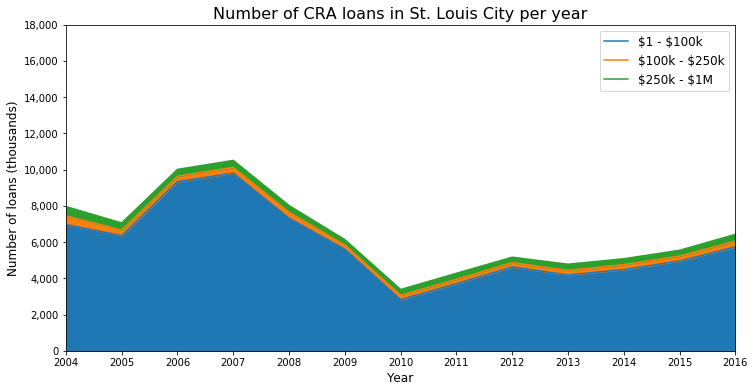

In [14]:
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
years_df[['nLoans1', 'nLoans100k', 'nLoans250k']].plot.area(ax=ax1)
plt.xlim([2004, 2016])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of loans (thousands)', fontsize=12)

plt.xticks(np.arange(2004,2017))
yticks = np.arange(0,20000,2000)
ylabels = ['{0:,.0f}'.format(y) for y in yticks]
plt.yticks(yticks, ylabels)

plt.legend(["\$1 - \$100k", "\$100k - \$250k", "\$250k - \$1M"], fontsize=12)
plt.title('Number of CRA loans in St. Louis City per year', fontsize=16)

plt.savefig(figdir+'stl_nLoans_per_year.jpg', format='jpg')
print('Done!')
#plt.show()

Done!


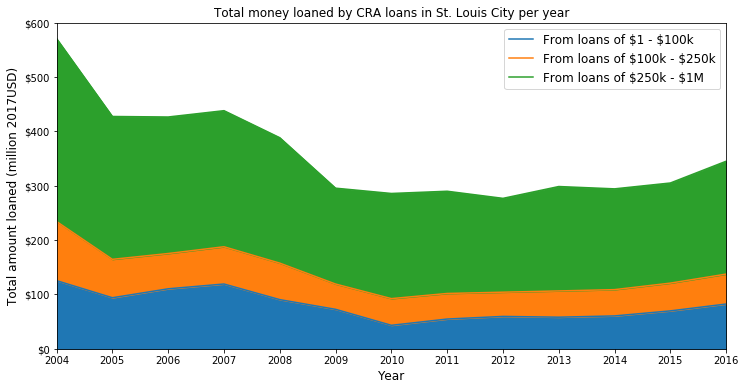

In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
years_df[['amtLoans1_adj', 'amtLoans100k_adj', 'amtLoans250k_adj']].plot.area(ax=ax1)
plt.xlim([2004, 2016])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total amount loaned (million 2017USD)', fontsize=12)

plt.xticks(np.arange(2004,2017))
yticks = np.arange(0,700000000,100000000)
yticklabels = ['${0:,.0f}'.format(y/1000000) for y in yticks]
plt.yticks(yticks, yticklabels)

plt.legend(["From loans of \$1 - \$100k", "From loans of \$100k - \$250k", "From loans of \$250k - \$1M"], fontsize=12)
plt.title('Total money loaned by CRA loans in St. Louis City per year')
#plt.show()
plt.savefig(figdir+'stl_amtLoans_per_year.jpg', format='jpg')
print('Done!')

In [21]:
print('getting from backup...')
institutions_df = institutions_df_bk

grand_total_nloans = institutions_df['nLoans'].sum()
grand_total_amtloans_adj = institutions_df['amtLoans_adj'].sum()

respondentid_df = pandas.read_csv('datasets/respondentid.csv')

institutions_df = institutions_df.drop('institution_name', axis=1)
institutions_df = institutions_df.reset_index().merge(respondentid_df, how='left', on='respondentID').set_index('respondentID')

institution_names_df = institutions_df.groupby('institution_name')[institutions_df.columns[:-1]].sum()

institution_names_df = institution_names_df.assign(pct_nloans = institution_names_df['nLoans'].apply(lambda x: x / grand_total_nloans))
institution_names_df = institution_names_df.assign(pct_amtloans_adj = institution_names_df['amtLoans_adj'].apply(lambda x: x / grand_total_amtloans_adj))
institution_names_df = institution_names_df.sort_values(by='nLoans', ascending=False)

htmlString = '<p><strong>Institutions responsible for >= 0.1% of all loans (adds up 35% of {0:,.0f} total loans):</strong></p>'.format(institution_names_df['nLoans'].sum())
htmlString += '<table><tr><th>Institution</th><th>Number of loans</th><th>Percent of all loans</th></tr>'

for thisbank, thisrow in institution_names_df[['nLoans', 'pct_nloans']][institution_names_df['pct_nloans'] >= 0.001].iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(thisbank)
    htmlString += '<td>{0:,.0f}</td>'.format(thisrow['nLoans'])
    htmlString += '<td>{0:.1%}</td>'.format(thisrow['pct_nloans'])
    htmlString += '</tr>'
htmlString += '</table>'

display(HTML(htmlString))


getting from backup...


Institution,Number of loans,Percent of all loans
"Chase Bank USA, NA (DE)","5,599",6.6%
US BANK NA (WI),"5,370",6.4%
"American Express, FSB (UT)","4,490",5.3%
"Capital One Bank (USA), N.A. (VA)","2,567",3.0%
"CITIBANK, N.A. (NY)","2,257",2.7%
"Bank of America, N.A. (CA)","1,834",2.2%
Synchrony Bank (UT),"1,572",1.9%
TEXAS CAPITAL BANK (TX),"1,561",1.9%
PNC BANK N.A. (PA),"1,195",1.4%
"Capital One, N.A. (VA)",790,0.9%


In [20]:
institution_names_df = institution_names_df.sort_values(by='amtLoans_adj', ascending=False)

htmlString = '<p><strong>Institutions responsible for >= 0.1% of amount loaned (adds up 20% of ${0:,.0f} total money loaned):</strong></p>'.format(institution_names_df['amtLoans_adj'].sum())
htmlString += '<table><tr><th>Institution</th><th>Amount loaned</th><th>Percent of money loaned</th></tr>'

for thisbank, thisrow in institution_names_df[['amtLoans_adj', 'pct_amtloans_adj']][institution_names_df['pct_amtloans_adj'] >= 0.001].iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(thisbank)
    htmlString += '<td>${0:,.0f}</td>'.format(thisrow['amtLoans_adj'])
    htmlString += '<td>{0:.1%}</td>'.format(thisrow['pct_amtloans_adj'])
    htmlString += '</tr>'
htmlString += '</table>'

display(HTML(htmlString))


Institution,Amount loaned,Percent of money loaned
US BANK NA (WI),"$294,761,170",6.4%
"Bank of America, N.A. (CA)","$218,031,751",4.7%
PNC BANK N.A. (PA),"$140,442,409",3.0%
"Chase Bank USA, NA (DE)","$56,811,423",1.2%
"BMO Harris Bank, N.A. (IL)","$52,806,554",1.1%
"American Express, FSB (UT)","$48,007,743",1.0%
"WELLS FARGO BANK, N.A. (CA)","$25,451,219",0.5%
TEXAS CAPITAL BANK (TX),"$25,370,918",0.5%
"CITIBANK, N.A. (NY)","$16,572,530",0.4%
"Capital One Bank (USA), N.A. (VA)","$14,810,381",0.3%
